https://stackoverflow.com/questions/34033785/normalize-values-in-dataframe

## Libraries

In [181]:
import pandas as pd
import re
import numpy as np
import spacy
import textblob
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import robust
from string import punctuation
import gensim
from gensim.models import word2vec
from string import punctuation as punct

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import v_measure_score

# Neural Network
from sklearn.neural_network import MLPClassifier

# for mac only: frog,blow,funk,glass,tink,submarine,purr,sosumi
def beep(audio): 
    os.system('afplay /System/Library/Sounds/' + audio +'.aiff')

# 1. Import and Add Basic Features

In [150]:
review = pd.read_csv('../data/boardgame/boardgame-comments-english.csv')

In [155]:
import random

In [160]:
review.columns = 'reviewer_id', 'game_id', 'rating', 'comment'
unique_id = review.reviewer_id.unique()
sample_id = random.sample(unique_id.tolist(),200)
reviewsample = review[review['reviewer_id'].isin(unique_id)]

In [139]:
comments = review.comment

__Round Ratings__

In [140]:
# RATINGS ADJUSTMENT: ceiling >= .5 [or] floor < .5
review['rating'] = review.rating.apply(round)

__Show ReviewerID and GameID Counts__

In [141]:
# Check for null values
review.isnull().any()

reviewer_id    False
game_id        False
rating         False
comment        False
dtype: bool

# __2. Ratings Distribution__

_A. Bayesian Average_

B. Min/Max Transform (Sklearn Preprocessing Doesn't Apply)

_C. Normalize by User Ratings (Not Working Yet)_

https://stackoverflow.com/questions/34033785/normalize-values-in-dataframe

_D. Log Probability Distribution [NOT CORRECT]_

In [166]:
plt.figure(figsize=(9.2,4))
plt.plot(np.log([review.rating[review.rating == i].sum()/review.rating.sum() for i in n]))
plt.title('Log Probability Rating Distribution')
plt.show()

NameError: name 'n' is not defined

<Figure size 662.4x288 with 0 Axes>

# 3. Natural Language Processing Features:

In [66]:
# Functions for finding percentage frequency (capital letters/punctuation)
def per_check(string_value, total):
    percentage = len(string_value)
    if percentage != 0:
        percentage = float(total / percentage) * 100
    else:
        percentage = 0
    return percentage

def punc_count(string_value):
    count = 0
    for c in string_value:
        if c in punctuation:
            count+= 1
    return per_check(string_value, count)

def caplet_count(string_value):
    count = 0
    for c in string_value:
        if c.isupper():
            count+= 1
    return per_check(string_value, count)      

review['c_len'] = review.comment.apply(len)
review['punc_count'] = review.comment.apply(punc_count)
review['caplet_count'] = review.comment.apply(caplet_count)

## _Spacy_

In [67]:
nlp = spacy.load('en')

In [68]:
%%time
docs = []
tokens = []
lemma = []
pos = []
deps = []
ents = []
sentences = []

def insert_null(l):
    return [(w if w else '0') for w in l]

pipeline = nlp.pipe(review['comment'].astype('unicode').values,
                    batch_size = 10, 
                    n_threads=4)

CPU times: user 572 µs, sys: 22 µs, total: 594 µs
Wall time: 584 µs


In [69]:
# Create doc
review['doc'] = [doc if doc.is_parsed else None for doc in pipeline]
beep('ping')

In [70]:
# apply features
review['w_len'] = review.doc.apply(len)
review['tokens'] = review.doc.apply(lambda doc: insert_null([tok.text for tok in doc]))
review['lemma'] = review.doc.apply(lambda doc: insert_null([tok.lemma_ for tok in doc]))
review['pos'] = review.doc.apply(lambda doc: insert_null([tok.pos_ for tok in doc]))
review['deps'] = review.doc.apply(lambda doc: insert_null([tok.dep_ for tok in doc]))
review['ents'] = review.doc.apply(lambda doc: insert_null([tok.ent_type_ for tok in doc]))
beep('ping')

## _TextBlob_

In [72]:
%%time
blobs = review.comment.apply(lambda val: textblob.TextBlob(val))

CPU times: user 39.4 ms, sys: 4.35 ms, total: 43.8 ms
Wall time: 43.6 ms


In [73]:
review['sent_pol'] = blobs.apply(lambda val: val.sentiment[0])
review['sent_subj'] = blobs.apply(lambda val: val.sentiment[1])

_Pol = Sentiment Polarity (positive or negative word choice)_ <br>
_Subj = Sentiment Subjectivity (objective or subjective word choice)_

In [74]:
# Additional Textblob Features (Not included because of Spacy)
review['wc'] = blobs.apply(lambda val: len(val.words))
review['sc'] = blobs.apply(lambda val: len(val.sentences))
review['tokens'] = blobs.apply(lambda val: [w.lower() for w in val.words])
review['pos'] = blobs.apply(lambda val: [v[1] for v in val.tags])

# 3. Visuals

# 4. Models

In [75]:
features = ['c_len','caplet_count','punc_count','rating','sent_pol','sent_subj']

In [76]:
%%time
y = review['rating']
X = review[features].drop('rating',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

CPU times: user 3.93 ms, sys: 940 µs, total: 4.87 ms
Wall time: 4.13 ms


In [77]:
X_train.head()

,c_len,caplet_count,punc_count,sent_pol,sent_subj
569611,34,5.882353,8.823529,1.000000,0.300000
486024,33,3.030303,18.181818,0.500000,0.400000
37120,104,4.807692,4.807692,0.283333,0.638889
401751,133,0.751880,1.503759,0.137500,0.487500
520649,202,3.465347,2.970297,0.043750,0.250000


### _Cluster Model_

_Tries to find clusters in the data but doesnt predict anything_ (Not currently relevant)

In [78]:
pca = PCA(n_components=2)
X_train_pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_train_pca_df = pd.DataFrame(X_train_pca)

In [79]:
%%time
c_range = range(2,13)
predict = []
for i in c_range:
    # Declare and fit the model.
    sc = SpectralClustering(n_clusters=i)
    predict.append(sc.fit_predict(X_train_pca_df))

    #Predicted clusters.
    print('{} completed'.format(i))

2 completed
3 completed
4 completed
5 completed
6 completed
7 completed
8 completed
9 completed
10 completed
CPU times: user 6min 33s, sys: 3.61 s, total: 6min 37s
Wall time: 3min 33s


## _V-Measurement Test_

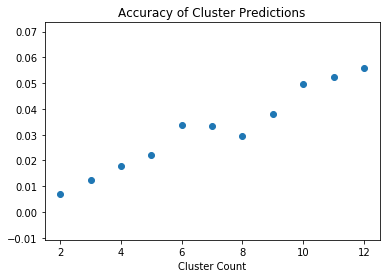

In [122]:
plt.scatter(x=[c_range],y=[v_measure_score(y_train,v) for v in predict])
plt.title('Accuracy of Cluster Predictions')
plt.xlabel('Cluster Count')
plt.show()

# for i,v in enumerate(predict):
#     print(clusters[i])
#     print(v_measure_score(y_train,predict[i]))

## _Likelihood Function_

$$ p(Y\mid\theta) = \prod_i^n {p({y_i}\mid\theta)} $$

## _Maximum Likelihood Function_

https://wikimedia.org/api/rest_v1/media/math/render/svg/9dc95691ee450e85995f5e3263600cb904323ee8

$$ \frac{1}{n}\sum_i^n \ln{p({y_i}\mid\theta)} $$

### _Logistic Regression_

_Operates on probabilities_

# 5. Word Embedding - Word2Vec

### TBD

__Cosine Similarity Function__

$$ cos(\theta) = \frac{A \bullet B} {\Vert A \Vert \Vert B \Vert} =  \frac{\sum_{i=1}^n A_i B_i}{\sqrt{ \sum_{i=1}^n A^2} \sqrt{ \sum_{i=1}^n B^2}} $$

__Version A. Raw Code__

__Version B. SKLearn__

______

******

# 6. Comprehensive Neural Network

_Slow Method_

_Fast Method_

_Create Train/Test Data_

In [ ]:
# Jon's Code
from scipy.sparse import vstack

# version for separated X and y arrays, X is vectorized text 
def balance_data_vec(X, y):
    minsamples = y.shape[0]
    ratings = list(range(1,11))

    # get min number of samples per rating level: 
    #   we'll use this as our sample size for every rating level.
    for rating in ratings:
        sampsize = (y==rating).sum()
        if sampsize < minsamples:
            minsamples = sampsize

    # take same number of samples for each rating level.
    # sample randomly, create a new dataframe with all samples
    X_bal = []
    y_bal = []
    for rating in ratings:
        X_r = X['rating'==rating]
        y_r = y[y==rating]
        idx = list(range(X_r.shape[0]))
        np.random.shuffle( idx )
        
        # create the output arrays
        if type(X_bal) == list: 
            X_bal = X_r[idx[:minsamples],:]
            y_bal = np.array([rating]*minsamples)
            
        # add samples to output arrays
        else:
            X_bal = vstack((X_bal, X_r[idx[:minsamples],:]))
            y_bal = np.append(y_bal, np.array([rating]*minsamples), axis=0 )
            
    # shuffle all samples
    idx = list(range(X_bal.shape[0])) 
    np.random.shuffle( idx )
    X_bal = X_bal[idx,:]
    y_bal = y_bal[idx]
    
    return X_bal, pd.Series(y_bal)

In [119]:
%%time
y = review['rating']
X = pd.DataFrame([list(i[0]) for i in review.vectors])

X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int).ravel(), test_size=0.33, random_state=42)

CPU times: user 128 ms, sys: 3.8 ms, total: 132 ms
Wall time: 131 ms


#### _C - Keras Sequential NN_

In [12]:
y_test = y_test.ravel()
y_train = y_train.ravel()

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [13]:
X_train.shape

(5638, 50)

In [15]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(vec_size,)))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(11, activation='softmax'))

In [16]:
batch_size = 5
epochs = 10

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              52224     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 11)                11275     
Total params: 1,113,099
Trainable params: 1,113,099
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

beep('ping')

Train on 5638 samples, validate on 2778 samples
Epoch 1/10
5638/5638 [==============================] - 14s 2ms/step - loss: 2.0421 - acc: 0.2504 - val_loss: 2.0009 - val_acc: 0.2603
Epoch 2/10
5638/5638 [==============================] - 14s 2ms/step - loss: 2.0298 - acc: 0.2691 - val_loss: 2.0170 - val_acc: 0.2891
Epoch 3/10
5638/5638 [==============================] - 14s 2ms/step - loss: 2.0256 - acc: 0.2731 - val_loss: 2.0363 - val_acc: 0.2801
Epoch 4/10
5638/5638 [==============================] - 15s 3ms/step - loss: 2.0364 - acc: 0.2728 - val_loss: 2.0593 - val_acc: 0.2577
Epoch 5/10
5638/5638 [==============================] - 14s 3ms/step - loss: 2.0292 - acc: 0.2726 - val_loss: 2.0183 - val_acc: 0.2991
Epoch 6/10
5638/5638 [==============================] - 14s 3ms/step - loss: 2.0157 - acc: 0.2824 - val_loss: 2.0870 - val_acc: 0.3006
Epoch 7/10
5638/5638 [==============================] - 14s 3ms/step - loss: 2.0326 - acc: 0.2921 - val_loss: 2.0827 - val_acc: 0.2855
Epoch 8

In [20]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.166683900004415
Test accuracy: 0.2670986321630711


In [21]:
# Jon's Code
from sklearn.metrics import confusion_matrix

def plot_confusion(y, y_pred, title):
    # rating levels
    ratings = list(range(1,11))

    # generate confusion matrix
    cm = confusion_matrix(y, y_pred)

    # normalize matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plot matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.magma)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(ratings))
    plt.xticks(tick_marks, ratings, rotation=45)
    plt.yticks(tick_marks, ratings)
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('Actual rating')
    plt.xlabel('Predicted rating');

In [23]:
y_predict = model.predict(X_test)

In [26]:
from keras.backend import argmax as kargmax
y_predict = np.argmax(model.predict(X_test),axis=1)
final_score = np.argmax(y_test,axis=1)

In [ ]:
imblearn

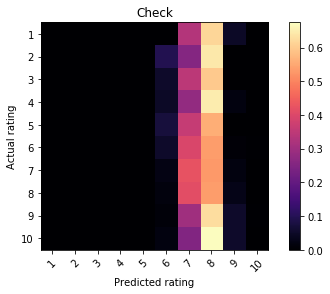

In [28]:
plot_confusion(final_score,y_predict,'Check')

## Word Similarity Visualization

## _Root Mean Squared Error_

$$ RMSE_{y} =  \sqrt{\frac{\sum_{i=1}^n {(\hat{y}_{i}- y_{i})}^2}{N}} $$

In [ ]:
RMSE = np.sqrt(np.sum(np.square(np.subtract(y_predict,y_actual)))/len(y_actual))
# print('Root Mean Squared Error: {}'.format(RMSE))

### _Notes_

Mathjacks / Tex